In [ ]:
# !apt-get update --fix-missing

# try:
#     import firedrake
# except ImportError:
#     !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
#     import firedrake

The available potential energy (APE) of a buoyancy field $B(\boldsymbol{x})$ of vertical extent $Z(\boldsymbol{x})$ is given by the difference of its actual potential energy and the (minimal) potential energy 
\begin{equation}
\mathbb{E}[BZ^*]  - \mathbb{E}[BZ] = \iint b \left(Z^*(b) -z \right) \; f_{BZ}(b,z) \; dbdz,
\end{equation}
where the reference state
\begin{equation}
Z^*(b) = F^{-1}_Z \circ F_B(b) = Q_Z \circ F_B(b),
\end{equation}
corresponds to an adiabatic volume preserving rearrangement of the fluid into a state that minimises PE. To calculate this quantity therefore requires an estimation of the buoyancy's PDF $f_B$, CDF $F_B$ as well as the vertical cordinate's QDF $Q_Z = F_Z^{-1}$.

As an example of a buoyancy field and potential we will consider
\begin{align}
    B(x_1,x_2) &= x_2 + \epsilon \sin(2 \pi x_2) \sin(\pi x_1),\\
    Z(x_1,x_2) &= x_2,
\end{align}
such that the physical domain is given by $\Omega_X \in [-1,1] \times [0,1]$, the buoyancy domain $\Omega_B \in [-1,1]$ and that of the potential by $\Omega_Z \in [0,1]$. The parameter $\epsilon$ will be used to swich on and off a more complicated functional dependency.

To construct the buoyancy's PDF & CDF $f_B,F_B$ and the vertical cordinate's QDF $F_Z^{-1}$ we make use of the **PDF_Projector** class imported below.

In [132]:
from PDF_Projector import *

ε, π = 1, np.pi

We first set up the function spaces and domain of the buoyancy $B$

In [133]:
# Set the function space
ptp_FB = FEptp(func_space_CDF = {"family":"DG","degree":1},func_space_PDF={"family":"CG","degree":1})

# Set the domain
x1,x2,b = ptp_FB.domain(Omega_X = {'x1':(-1,1),'x2':(0,1)}, Omega_Y = {'Y':(0,1)}, N_elements=10)

2D mesh


/home/pmannix/Dstratify/Finite_Element/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


Using this domain we then compute the CDF and PDF of the buoyancy field, by calling the fit method.

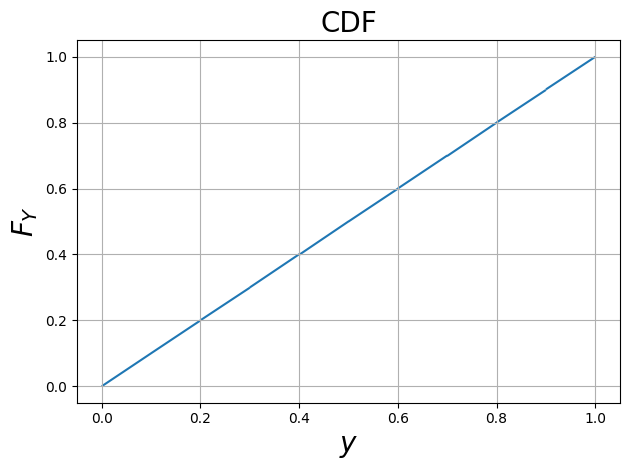

In [134]:
# Construct the PDF,CDF,QDF
ptp_FB.fit(function_Y = x2, quadrature_degree=100) # + ε*sin(π*x1)*sin(2*π*x2)

ptp_FB.plot(function='CDF')

To obtain the QDF of the co-ordinate field $Z$ we follow a similar procedure. Specifying first the function spaces and domain of the coordinate field followed by calling the fit method.

2D mesh


/home/pmannix/Dstratify/Finite_Element/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


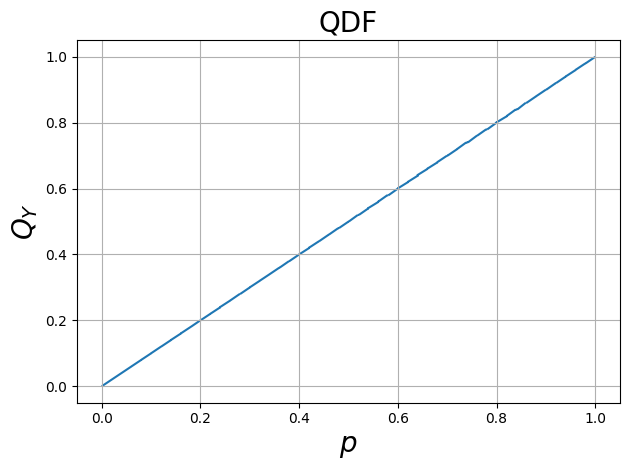

In [135]:
# Set the function space
ptp_FZ = FEptp(func_space_CDF = {"family":"DG","degree":1})

# Set the domain
x1,x2,z = ptp_FZ.domain(Omega_X = {'x1':(-1,1),'x2':(0,1)}, Omega_Y = {'Y':(0,1)}, N_elements=50)

# Construct the PDF,CDF,QDF
ptp_FZ.fit(function_Y = x2, quadrature_degree=200)

ptp_FZ.plot(function='QDF')

Having obtained all necessary functions it remains to obtain the reference height $Z^*(b)$ and evaluate the integral to compute the APE. To obtain the reference height we construct a function Z_ref as below using a quadrature element. At the nodes of the quadrature element we shall evaluate the function composition $Z^*(b) = Q_Z \circ F_B(b)$.

In [136]:
# Define a function space for Z_ref
quadrature_degree = 10

V_ZE    = FiniteElement(family="Quadrature",cell="interval",degree=quadrature_degree,quad_scheme='default')
V_Z     = FunctionSpace(mesh=ptp_FB.m_y ,family=V_ZE)
Z_ref   = Function(V_Z)

With the quadrature element defined we now grab the quadrature points $b_q$

In [137]:
# First, grab the mesh.
m = V_Z.mesh()

# Now make the VectorFunctionSpace corresponding to V.
W = VectorFunctionSpace(m, V_Z.ufl_element())

# Next, interpolate the coordinates onto the nodes of W.
X = assemble(interpolate(m.coordinates, W))

We now avail of a vertex only mesh in order to compute $F_q = F_B(b_q)$, the CDF evaluated at the quadrature points $b_q$. 

In [138]:
b_q = [ [b_i,] for b_i in X.dat.data[:]]
vom = VertexOnlyMesh(ptp_FB.m_y, b_q)

# P0DG is the only function space you can make on a vertex-only mesh
P0DG = FunctionSpace(vom, "DG", 0)

# Interpolation performs point evaluation
# [test_vertex_only_mesh_manual_example 2]
F = assemble(interpolate(ptp_FB.F, P0DG))

And using the same methods again we compute $Q_q = Q_Y(F_q)$, QDF evaluated at the points $F_q = F_B(b_q)$.

In [139]:
F_q = [ [F_i,] for F_i in F.dat.data[:]]
vom = VertexOnlyMesh(ptp_FZ.m_p, F_q)

# P0DG is the only function space you can make on a vertex-only mesh
P0DG = FunctionSpace(vom, "DG", 0)

# Interpolation performs point evaluation
# [test_vertex_only_mesh_manual_example 2]
Q_q = assemble(interpolate(ptp_FZ.Q, P0DG))

Finally we parse these values into the dofs of Z_ref

In [140]:
Z_ref.dat.data[:] = Q_q.dat.data[:]

To evaluate the background potential energy or BPE we can then integrate the expression
\begin{equation}
\mathbb{E}[BZ^*] = \int b Z^*(b) f_{B}(b) \; db
\end{equation}
as implemented below

In [149]:
b,  = SpatialCoordinate(ptp_FB.m_y)
BPE = assemble( Z_ref*b*ptp_FB.f*dx(degree=quadrature_degree) )

print('BPE = ',BPE)

BPE =  0.33166866763262964
